In [1]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("../input/emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("../input/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [3]:
# Constants
HEIGHT = 28
WIDTH = 28

In [4]:
# Split x and y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [5]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [6]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [7]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [8]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255


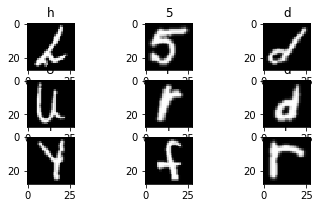

In [9]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y[i]]))

In [10]:
# number of classes
num_classes = train_y.nunique()

In [11]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [12]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [13]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)

In [14]:
# Building model
# ((Si - Fi + 2P)/S) + 1
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))

Train on 101519 samples, validate on 11280 samples
Epoch 1/10
101519/101519 [==============================] - 16s 162us/step - loss: 1.6093 - acc: 0.5438 - val_loss: 0.5655 - val_acc: 0.8128
Epoch 2/10
101519/101519 [==============================] - 11s 112us/step - loss: 0.7823 - acc: 0.7520 - val_loss: 0.4541 - val_acc: 0.8395
Epoch 3/10
101519/101519 [==============================] - 11s 112us/step - loss: 0.6438 - acc: 0.7916 - val_loss: 0.4199 - val_acc: 0.8520
Epoch 4/10
101519/101519 [==============================] - 11s 112us/step - loss: 0.5752 - acc: 0.8104 - val_loss: 0.3905 - val_acc: 0.8598
Epoch 5/10
101519/101519 [==============================] - 11s 112us/step - loss: 0.5319 - acc: 0.8221 - val_loss: 0.3741 - val_acc: 0.8661
Epoch 6/10
101519/101519 [==============================] - 11s 112us/step - loss: 0.4970 - acc: 0.8332 - val_loss: 0.3651 - val_acc: 0.8694
Epoch 7/10
101519/101519 [==============================] - 11s 112us/step - loss: 0.4778 - acc: 0.8387

In [17]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [18]:
#%%
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

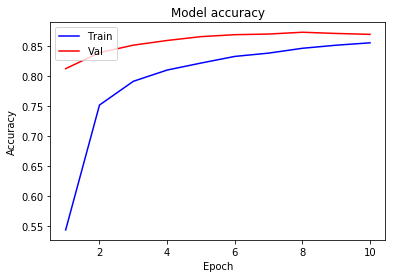

In [19]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

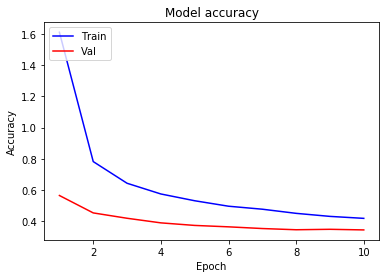

In [20]:
# loss curve
plotgraph(epochs, loss, val_loss)

In [21]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36574761957584895
Test accuracy: 0.8728655779626155


In [22]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

In [23]:
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))